## 8.5. 循环神经网络的从零开始实现

In [2]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

c:\Users\yy200\miniconda3\envs\d2l\lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### 8.5.1 独热编码
回想一下，在train_iter中，每个词元都表示为一个数字索引， 将这些索引直接输入神经网络可能会使学习变得困难。 我们通常将每个词元表示为更具表现力的特征向量。

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [14]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### 8.5.2 初始化模型参数

In [9]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 8.5.3. 循环神经网络模型

In [4]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [5]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [12]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, 
                 get_params, init_state, forward_fn):
        self.vocab_size = vocab_size
        self.num_hiddens = num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state = init_state
        self.forward_fn = forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [57]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

### 8.5.4. 预测

In [58]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [59]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller d<unk>lmslmslm'

### 8.5.5. 梯度裁剪
假设函数 $f$ 在常数 $L$ 下是利普希茨连续的（Lipschitz continuous）  
我们不会观察到超过 $L \eta \|\mathbf{g}\|$ 的变化。 这既是坏事也是好事。 坏的方面，它限制了取得进展的速度； 好的方面，它限制了事情变糟的程度，尤其当我们朝着错误的方向前进时。  
有时梯度可能很大，从而优化算法可能无法收敛。 我们可以通过降低学习率来解决这个问题。 但是如果我们很少得到大的梯度呢？ 在这种情况下，这种做法似乎毫无道理。 一个流行的替代方案是通过将梯度g投影回给定半径 （例如 $\theta$ ）的球来裁剪梯度
。 如下式：
$$
\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}.
$$
通过这样做，我们知道梯度范数永远不会超过 $\theta$ ， 并且更新后的梯度完全与g的原始方向对齐。 它还有一个值得拥有的副作用， 即限制任何给定的小批量数据（以及其中任何给定的样本）对参数向量的影响， 这赋予了模型一定程度的稳定性。 梯度裁剪提供了一个快速修复梯度爆炸的方法， 虽然它并不能完全解决问题，但它是众多有效的技术之一。

In [37]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 8.5.6 训练模型

In [39]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [40]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.1, 70483.5 词元/秒 cuda:0
time traveller with a slight accession ofcheerfulness really thi
traveller with a slight accession ofcheerfulness really thi


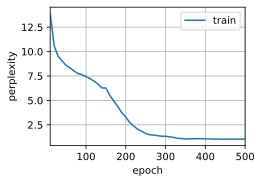

In [55]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.5, 68912.7 词元/秒 cuda:0
time travellerit s against reason said filbywan at time that is 
travellerit s against reason said filbywan at time that is 


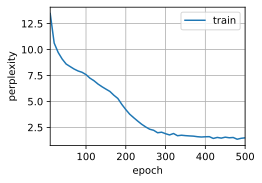

In [53]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

### 8.5.8 练习解答

1. **尝试说明独热编码等价于为每个对象选择不同的嵌入表示。**

    独热编码为每个对象分配一个唯一的向量，其中只有一个位置为1，其余位置为0。这种表示方式等价于为每个对象选择一个不同的嵌入表示，因为每个对象的独热编码向量在高维空间中是正交的，能够唯一标识该对象。

2. **通过调整超参数（如迭代周期数、隐藏单元数、小批量数据的时间步数、学习率等）来改善困惑度。**

    - **困惑度可以降低到多少？**  
      困惑度的理论下限是1，这意味着模型能够完美预测下一个字符。在实际中，困惑度的降低取决于数据的复杂性和模型的能力。

    - **用可学习的嵌入表示替换独热编码，是否会带来更好的表现？**  
      是的，可学习的嵌入表示通常能够捕获词元之间的语义关系，从而提高模型的表现。相比独热编码，嵌入表示能够更紧凑地表示词元，并减少计算复杂度。

    - **如果用 H.G.Wells 的其他书作为数据集时效果如何，例如《世界大战》？**  
      效果取决于数据集的规模和复杂性。如果数据集较大且具有丰富的语言模式，模型可能会表现更好。但如果数据集较小或语言模式较简单，模型可能会过拟合或无法充分学习。

3. **修改预测函数，例如使用采样，而不是选择最有可能的下一个字符。**

    - **会发生什么？**  
      使用采样可以生成更加多样化的文本，而不是总是选择最可能的字符。这种方法可以避免生成的文本过于单一或重复。

    - **调整模型使之偏向更可能的输出，例如，当 $\alpha > 1$，从 $q(x_t \mid x_{t-1}, \ldots, x_1) \propto P(x_t \mid x_{t-1}, \ldots, x_1)^\alpha$ 中采样。**  
      增大 $\alpha$ 会使模型更加偏向高概率的输出，从而减少生成的随机性；减小 $\alpha$ 则会增加生成的多样性，但可能会生成不合理的文本。

4. **在不裁剪梯度的情况下运行本节中的代码会发生什么？运行时间会有变化吗？困惑度呢？**  
    如果不裁剪梯度，可能会出现梯度爆炸现象，导致模型无法收敛或训练不稳定。运行时间可能会增加，因为梯度爆炸会导致数值计算异常。困惑度可能会变得非常高，甚至无法正常计算。

5. **更改顺序采样，使其不会从计算图中分离状态。运行时间会有变化吗？困惑度呢？**  
    如果不分离状态，计算图会随着时间步数的增加而变得越来越复杂，导致运行时间显著增加，并可能耗尽内存。困惑度可能会受到影响，因为梯度计算可能会变得不稳定。

6. **用 ReLU 替换本节中使用的激活函数，并重复本节中的实验。我们还需要梯度裁剪吗？为什么？**  
    使用 ReLU 激活函数可能会导致梯度爆炸或梯度消失问题，尤其是在深层网络中。因此，仍然需要梯度裁剪来限制梯度的范数，确保训练的稳定性。